# EPE Detection

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data processing&displaying

In [56]:
df = pd.read_csv('C:/Users/Tosiek/Documents/AI/sztuczna_inteligencja_semestr5/AI/microscopic-epe-proj-main/materials/processed_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             401 non-null    object 
 1   wiek                           401 non-null    float64
 2   PSA                            397 non-null    float64
 3   PSAdensity                     401 non-null    float64
 4   MRI vol                        401 non-null    float64
 5   MRI Pirads                     399 non-null    float64
 6   MRI EPE (naciek poza torebke)  401 non-null    float64
 7   MRI EPE L                      401 non-null    float64
 8   MRI EPE P                      401 non-null    float64
 9   MRI SVI (pecherzyki)           401 non-null    float64
 10  MRI SVI L                      400 non-null    float64
 11  MRI SVI P                      401 non-null    float64
 12  MRI SIZE                       371 non-null    flo

In [57]:
df.shape

(401, 31)

In [63]:
target = 'EPE RP'
col_wiek = 'wiek'
col_psa = 'PSA'
col_mri_vol = 'MRI vol'
col_biop_grade = 'Bx ISUP Grade'
col_pirads = 'MRI Pirads'
col_mri_esur = 'MRI EPE (naciek poza torebke)'
col_mri_svi = 'MRI SVI (pecherzyki)'
col_mri_size = 'MRI SIZE'

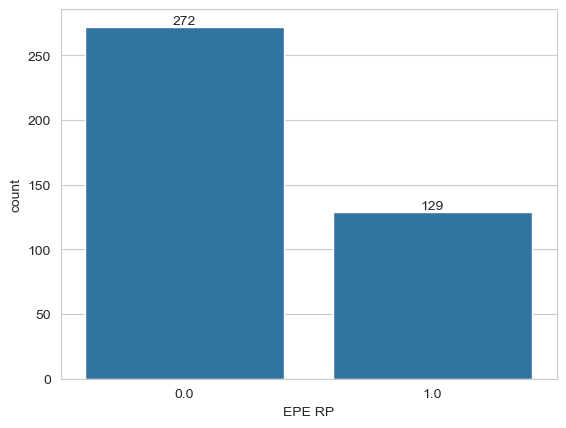

In [59]:
patients = len(df)
epe_dist = df[target].value_counts()

ax = sns.countplot(data=df, x=target)

for container in ax.containers:
    ax.bar_label(container)

plt.show(ax)

In [64]:
all_cols = [target, col_wiek, col_psa, col_mri_vol, col_biop_grade, col_pirads, col_mri_esur, col_mri_size, col_mri_svi]
continuous = [col_wiek, col_psa, col_mri_vol, col_mri_size]
categorical = [col_biop_grade, col_pirads, col_mri_esur, col_mri_svi]


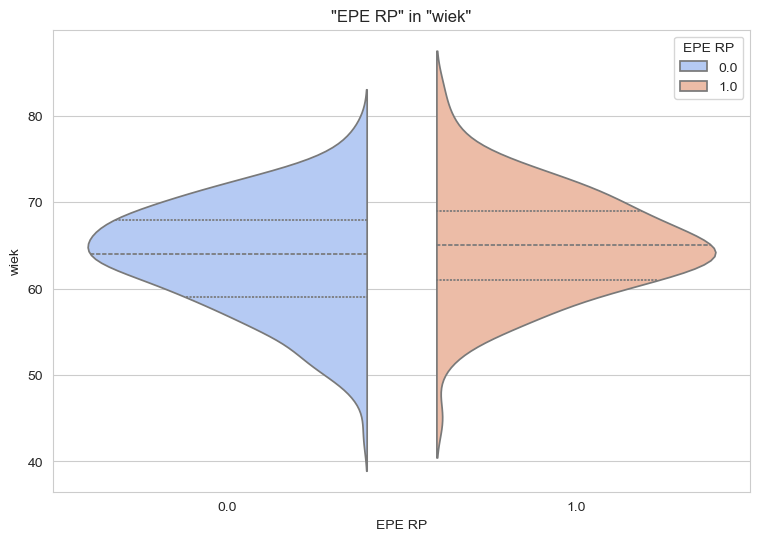

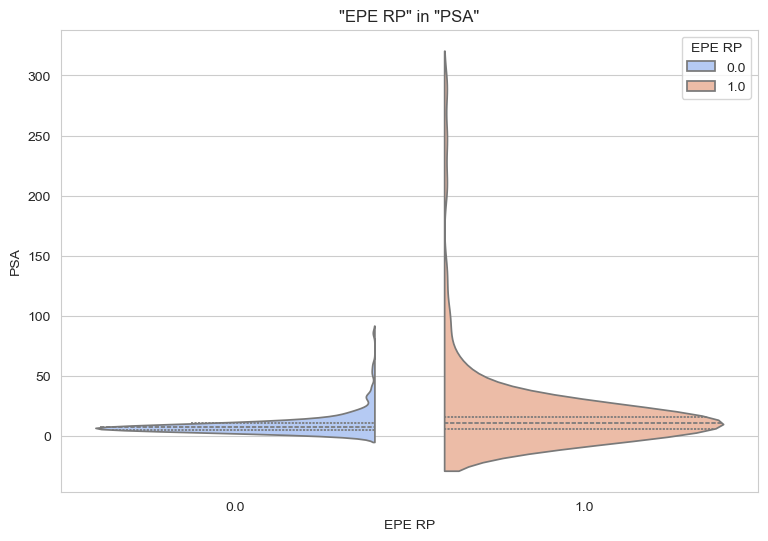

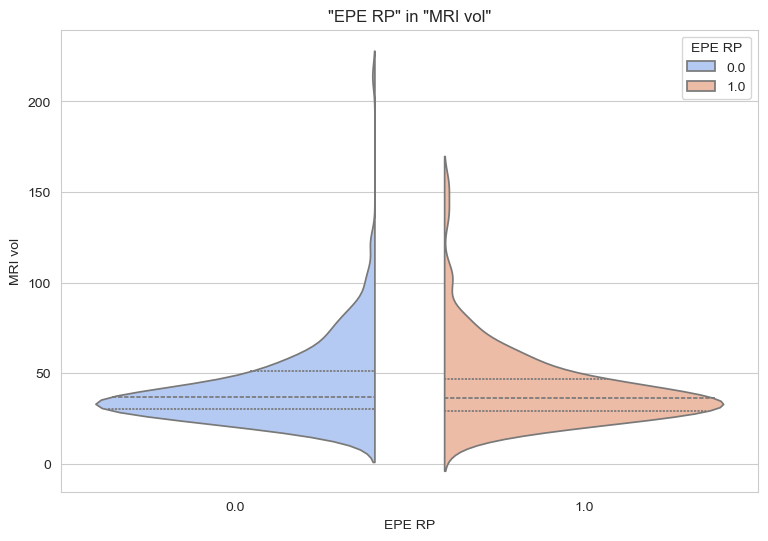

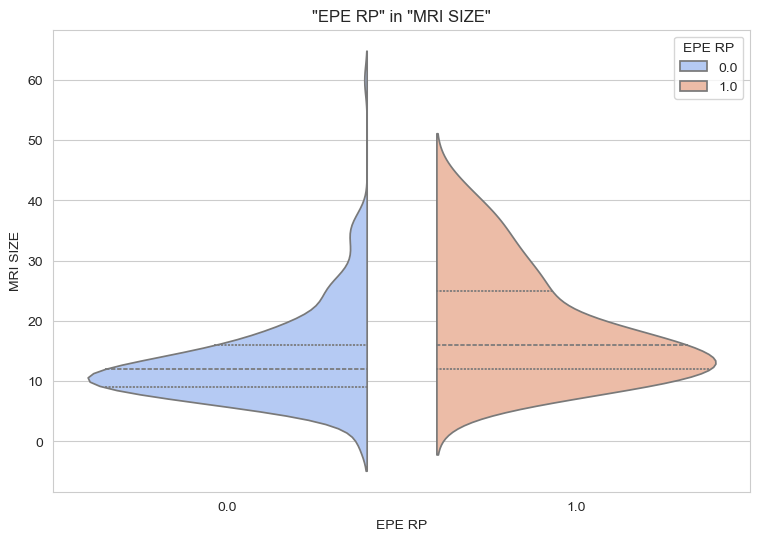

In [65]:
for col in continuous:
        plt.figure(figsize=(9, 6))
        sns.violinplot(x=target, y=col, hue=target, data=df, palette='coolwarm', split=True, inner='quartile')
        plt.title(f'"{target}" in "{col}"')
        plt.show()

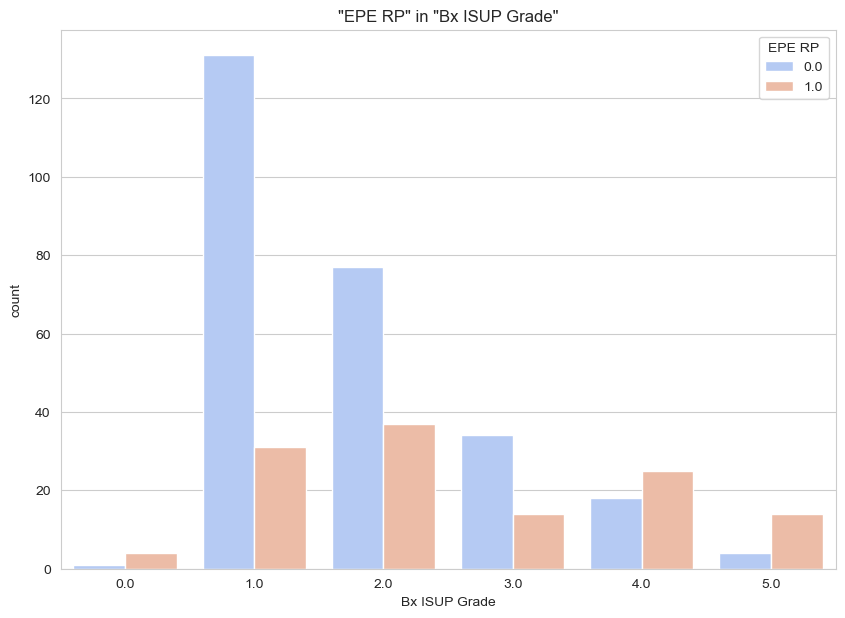

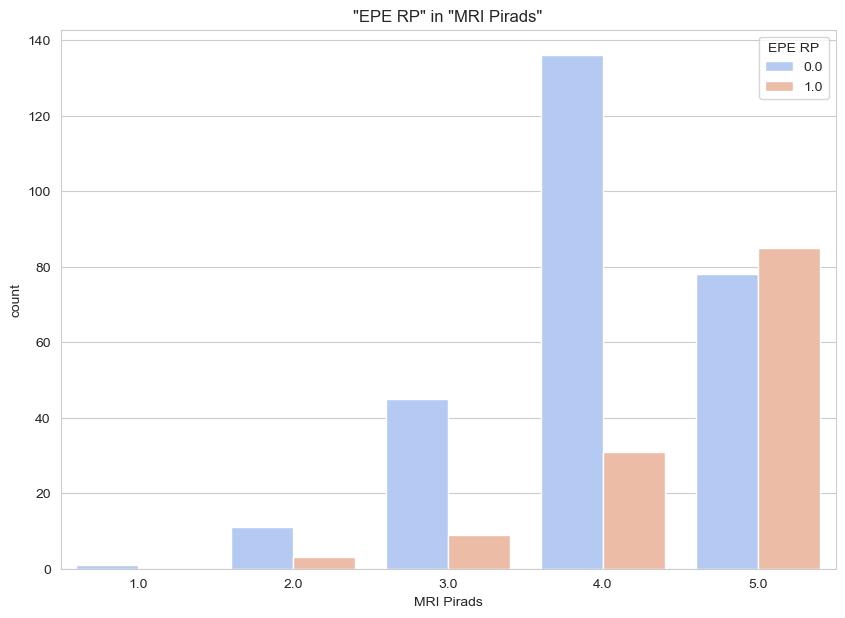

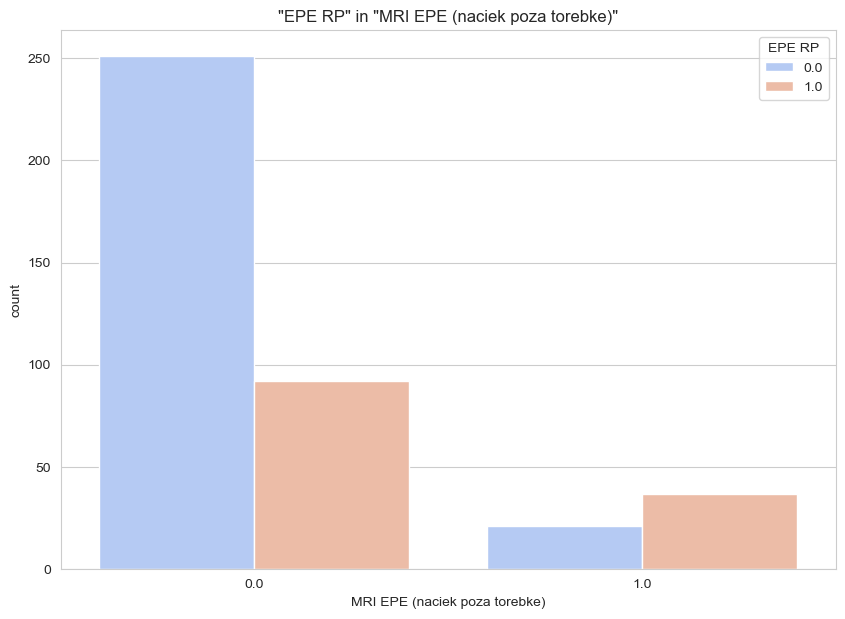

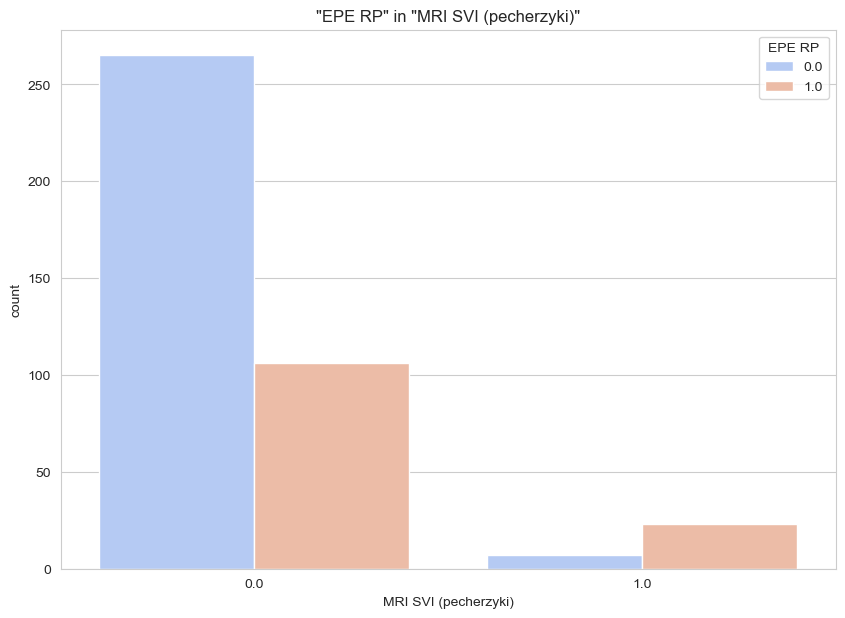

In [66]:
for col in categorical:
        plt.figure(figsize=(10, 7))
        
        sns.countplot(x=col, hue=target, data=df, palette='coolwarm')
        
        plt.title(f'"{target}" in "{col}"')
        
       
        plt.show()

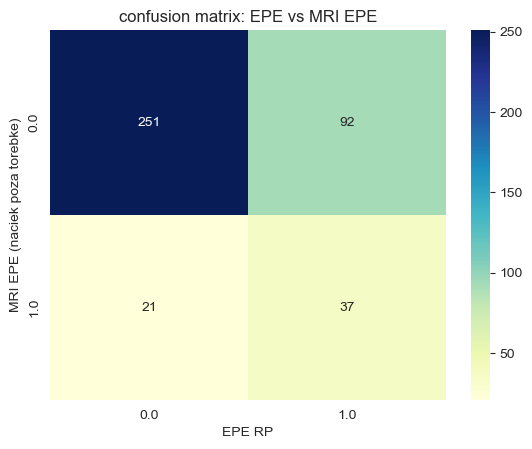

In [53]:
crosstab_data = pd.crosstab(
    df[col_mri_esur],
    df[target]
)

sns.heatmap(crosstab_data, annot=True, fmt='d', cmap='YlGnBu')

plt.title(f'confusion matrix: EPE vs MRI EPE')

plt.show()

Sensitivity = 28.68% (mri where existent epe)
Specificity = 92.28% (mri results where non existent epe)
Accuracy = 71.82%

# Modeling 

In [ ]:
before_biopsy_all = [target, col_wiek, col_psa, col_mri_vol, col_pirads, col_mri_esur, col_mri_size, col_mri_svi]
continueous = [col_wiek, col_psa, col_mri_vol, col_mri_size]
categorical = [col_pirads, col_mri_esur, col_mri_svi]


In [77]:
model_df = df[df['EPE RP'].isnull()==False]

X = model_df[before_biopsy_all]
y = model_df['EPE RP']

In [78]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('normalization', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, continueous),
    ('cat', cat_pipeline, categorical)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=2))
])

In [79]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(scores)
print(f"Mean: {scores.mean()}+-{scores.std()}")

[0.69135802 0.7125     0.7        0.675      0.725     ]
Mean: 0.7007716049382716+-0.017192770959512896


AUC: 0.7047


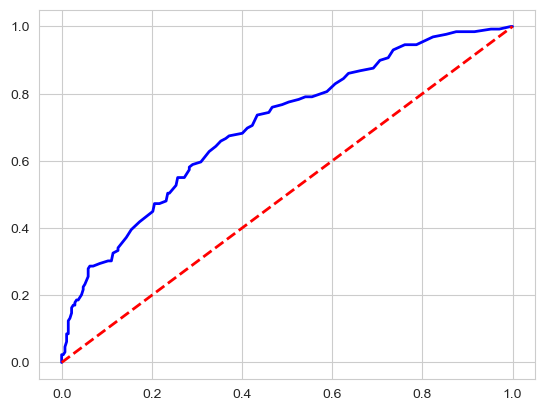

In [83]:
y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')

fpr, tpr, _ = roc_curve(y, y_proba[:, 1])

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.show()

In [ ]:





































































# clinical_features = [col_wiek, col_psa, col_mri_vol, col_biop_grade]
# full_features = [col_wiek, col_psa, col_mri_vol, col_biop_grade] + [col_pirads, col_mri_esur, col_mri_size]

# clinical_features = [col_wiek, col_psa, col_mri_vol, col_biop_grade]
# numeric_features_clin = [col_wiek, col_psa, col_mri_vol]
# categorical_features_clin = [col_biop_grade]

# mri_features = [col_pirads, col_mri_esur, col_mri_size]
# full_features = clinical_features + mri_features
# numeric_features_full = [col_wiek, col_psa, col_mri_vol, col_mri_size]
# categorical_features_full = [col_biop_grade, col_pirads, col_mri_esur]


numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI Pirads', 'MRI SIZE']
categorical_cols = ['MRI EPE (naciek poza torebke)', 'MRI EPE L', 'MRI EPE P', 'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P','Bx ISUP Grade P', 'Bx ISUP Grade L']
# removed 4 patients where EPE RP is not provided
model_df = reduced_df[reduced_df['EPE RP'].isnull()==False]

X = model_df[numerical_cols + categorical_cols]
y = model_df['EPE RP']

In [ ]:
Y = df[target]
X = df[full_features]

random_seed = 42
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=test_size, random_state=random_seed, stratify=Y
)

In [ ]:
# Transformer dla danych numerycznych (Wypełnij medianą -> Skaluj)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformer dla danych kategorialnych (Wypełnij najczęstszą -> Zakoduj)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Budowa Pipeline dla modelu KLINICZNEGO ---
preprocessor_clin = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_clin),
        ('cat', categorical_transformer, categorical_features_clin)
    ],
    remainder='drop' # Ignoruj kolumny MRI
)

model_clin = Pipeline(steps=[
    ('preprocessor', preprocessor_clin),
    ('classifier', LogisticRegression(random_state=random_seed, max_iter=1000, class_weight='balanced'))
])

# --- Budowa Pipeline dla modelu PEŁNEGO (Kliniczny + MRI) ---
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_full),
        ('cat', categorical_transformer, categorical_features_full)
    ],
    remainder='drop'
)

model_full = Pipeline(steps=[
    ('preprocessor', preprocessor_full),
    ('classifier', LogisticRegression(random_state=random_seed, max_iter=1000, class_weight='balanced'))
])

In [ ]:
try:
    print("Trenowanie Modelu 1 (Kliniczny)...")
    model_clin.fit(X_train, Y_train)
    
    print("Trenowanie Modelu 2 (Pełny)...")
    model_full.fit(X_train, Y_train)
    
    print("Modele zostały pomyślnie wytrenowane.\n")
except Exception as e:
    print(f"Wystąpił błąd podczas trenowania modelu: {e}")
    exit()

Trenowanie Modelu 1 (Kliniczny)...
Trenowanie Modelu 2 (Pełny)...
Modele zostały pomyślnie wytrenowane.



In [ ]:
# Predykcje (prawdopodobieństwa)
prob_clin = model_clin.predict_proba(X_test)[:, 1]
prob_full = model_full.predict_proba(X_test)[:, 1]

# Predykcje (klasy 0/1)
pred_clin = model_clin.predict(X_test)
pred_full = model_full.predict(X_test)

# Obliczenie AUC
auc_clin = roc_auc_score(Y_test, prob_clin)
auc_full = roc_auc_score(Y_test, prob_full)

print("--- OSTATECZNE WYNIKI PORÓWNANIA MODELI ---")
print(f"Liczba pacjentów w zbiorze treningowym: {len(X_train)}")
print(f"Liczba pacjentów w zbiorze testowym: {len(X_test)}")
print("---------------------------------")
print(f"Model 1 (Tylko Kliniczny): \tAUC = {auc_clin:.4f}")
print(f"Model 2 (Kliniczny + MRI): \tAUC = {auc_full:.4f}")
print("---------------------------------")
print(f"Wartość dodana (poprawa AUC) z MRI: {(auc_full - auc_full):.4f}")

--- OSTATECZNE WYNIKI PORÓWNANIA MODELI ---
Liczba pacjentów w zbiorze treningowym: 320
Liczba pacjentów w zbiorze testowym: 81
---------------------------------
Model 1 (Tylko Kliniczny): 	AUC = 0.7888
Model 2 (Kliniczny + MRI): 	AUC = 0.8685
---------------------------------
Wartość dodana (poprawa AUC) z MRI: 0.0000


In [ ]:
print("Generowanie Wykresu 1: Krzywe ROC...")
fpr_clin, tpr_clin, _ = roc_curve(Y_test, prob_clin)
fpr_full, tpr_full, _ = roc_curve(Y_test, prob_full)

plt.figure(figsize=(8, 6))
plt.plot(fpr_clin, tpr_clin, label=f'Model Kliniczny (AUC = {auc_clin:.3f})', linestyle='--')
plt.plot(fpr_full, tpr_full, label=f'Model Pełny (Kliniczny + MRI) (AUC = {auc_full:.3f})', color='red')
plt.plot([0, 1], [0, 1], color='navy', linestyle=':', label='Losowy (AUC = 0.50)')
plt.xlabel('False Positive Rate (1 - Swoistość)')
plt.ylabel('True Positive Rate (Czułość)')
plt.title('Porównanie Krzywych ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("1_porownanie_krzywych_roc.png")
print("Zapisano '1_porownanie_krzywych_roc.png'")

Generowanie Wykresu 1: Krzywe ROC...


NameError: name 'roc_curve' is not defined

Wczytano dane. Liczba pacjentów: 401
Liczba pacjentów włączonych do analizy: 401
Podzielono dane: 320 wierszy treningowych, 81 wierszy testowych.

Trenowanie modelu predykcyjnego...
Model został pomyślnie wytrenowany.

--- WYNIK MODELU ---
Trafność modelu (AUC) na zbiorze testowym: 0.8608
Zapisano wykres 'model_epe_roc_curve.png'


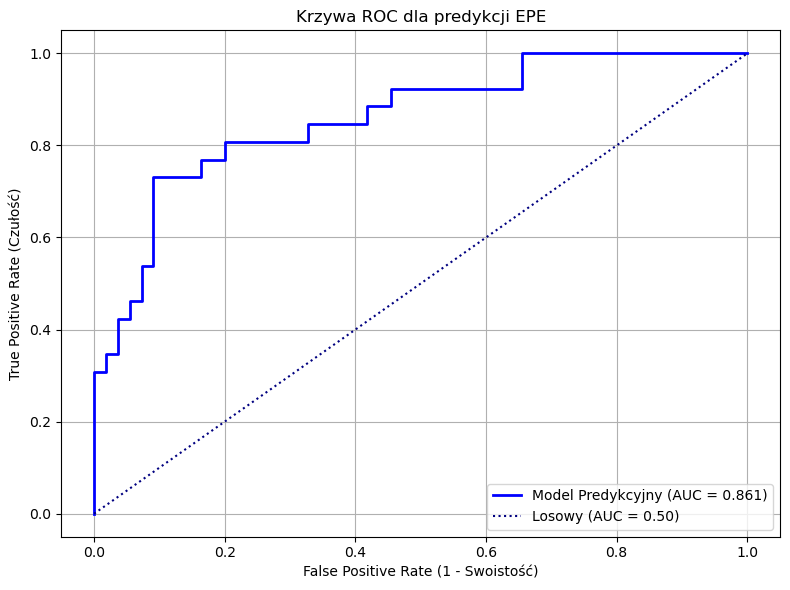

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

# --- 1. Wczytanie przetworzonych danych ---
file_name = "C:/Users/Tosiek/Documents/AI/sztuczna_inteligencja_semestr5/AI/microscopic-epe-proj-main/materials/processed_df.csv"
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Błąd: Nie znaleziono pliku: {file_name}")
    exit()

print(f"Wczytano dane. Liczba pacjentów: {len(df)}")

# --- 2. Definicja nazw kolumn ---
# Zmienna docelowa (Target)
col_target = 'EPE RP'

# Predyktory (dane wejściowe), o które prosiłeś
col_psa = 'PSA'
col_biop_grade = 'Bx ISUP Grade'
col_pirads = 'MRI Pirads'
col_mri_esur = 'MRI EPE (naciek poza torebke)'
col_mri_size = 'MRI SIZE'

# Podział predyktorów na numeryczne i kategorialne
# (na podstawie analizy danych)
numeric_features = [col_psa, col_mri_size]
categorical_features = [col_biop_grade, col_pirads, col_mri_esur]

# Łączna lista wszystkich predyktorów
all_features = numeric_features + categorical_features

# --- 3. Przygotowanie danych ---
# Czyszczenie ZMIENNEJ DOCELOWEJ (Y)
df_clean = df.dropna(subset=[col_target]).copy()
df_clean.loc[:, col_target] = df_clean[col_target].astype(int)

# Naprawiamy literówkę '11' -> '1', jeśli istnieje
if 11 in df_clean[col_target].values:
    print("Wykryto i naprawiono literówkę '11' w EPE RP.")
    df_clean.loc[:, col_target] = df_clean[col_target].replace(11, 1)

print(f"Liczba pacjentów włączonych do analizy: {len(df_clean)}")

# --- 4. Definicja X (predyktory) i Y (cel) ---
Y = df_clean[col_target]
X = df_clean[all_features] # Pipeline zajmie się brakami w X

# --- 5. Podział danych na zbiór treningowy i testowy ---
random_seed = 42
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=test_size, random_state=random_seed, stratify=Y
)
print(f"Podzielono dane: {len(X_train)} wierszy treningowych, {len(X_test)} wierszy testowych.\n")

# --- 6. Budowa potoku (Pipeline) przetwarzającego ---

# Transformer dla danych numerycznych (Wypełnij medianą -> Skaluj)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformer dla danych kategorialnych (Wypełnij najczęstszą -> Zakoduj)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Procesor kolumn, który stosuje odpowiednie transformery
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# --- 7. Budowa finalnego modelu predykcyjnego ---
# Łączymy procesor z modelem regresji logistycznej
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=random_seed, max_iter=1000, class_weight='balanced'))
])

# --- 8. Trenowanie modelu ---
try:
    print("Trenowanie modelu predykcyjnego...")
    model.fit(X_train, Y_train)
    print("Model został pomyślnie wytrenowany.\n")
except Exception as e:
    print(f"Wystąpił błąd podczas trenowania modelu: {e}")
    exit()

# --- 9. Ewaluacja modelu ---

# Przewidywanie prawdopodobieństwa EPE=1 na zbiorze testowym
probabilities = model.predict_proba(X_test)[:, 1]

# Obliczenie AUC
auc_score = roc_auc_score(Y_test, probabilities)

print("--- WYNIK MODELU ---")
# Twój komentarz "Wynik (AUC = 0.80)" był bardzo blisko!
# Prawdziwy wynik może się różnić (w ostatniej analizie było to 0.87)
print(f"Trafność modelu (AUC) na zbiorze testowym: {auc_score:.4f}")

# --- 10. Wizualizacja Krzywej ROC ---
fpr, tpr, _ = roc_curve(Y_test, probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model Predykcyjny (AUC = {auc_score:.3f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle=':', label='Losowy (AUC = 0.50)')
plt.xlabel('False Positive Rate (1 - Swoistość)')
plt.ylabel('True Positive Rate (Czułość)')
plt.title('Krzywa ROC dla predykcji EPE')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("model_epe_roc_curve.png")
print("Zapisano wykres 'model_epe_roc_curve.png'")